In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from tqdm import tqdm
import cv2
import glob

In [2]:
paths = glob.glob('C:\\xunleixiazai\\FERG_DB_256\\aia\\*\*.png')
paths[0]


'C:\\xunleixiazai\\FERG_DB_256\\aia\\AN\\aia_anger_1.png'

In [3]:
im=cv2.imread(paths[0],0)
print(im)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [4]:
emodic = {
    'AN' : 0,
    'DI' : 1,
    'FE' : 2,
    'HA' : 3,
    'NE' : 4,
    'SA' : 5,
    'SU' : 6, 
}


In [5]:
img = []
target = []
name = paths[0]
for i in paths:
    
    la = i.split('\\')[-2]
    im = cv2.imread(i,0)
    im = cv2.resize(im,(256,256))
    im = im.reshape(256,256,1)
    img.append(im)
    
    target.append(emodic[la])


In [6]:
img = np.array(img)
target = np.array(target)
img.shape , target.shape

((224, 256, 256, 1), (224,))

In [7]:
img = (img-127.5)/127.5

In [8]:
type(img[0])

numpy.ndarray

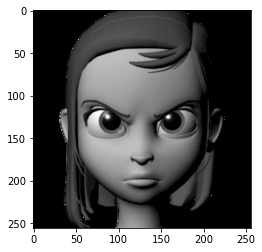

In [9]:
plt.imshow(img[0].reshape(256,256),cmap='gray')

In [10]:
dataset = [img,target]
dataset

[array([[[[-1.],
          [-1.],
          [-1.],
          ...,
          [-1.],
          [-1.],
          [-1.]],
 
         [[-1.],
          [-1.],
          [-1.],
          ...,
          [-1.],
          [-1.],
          [-1.]],
 
         [[-1.],
          [-1.],
          [-1.],
          ...,
          [-1.],
          [-1.],
          [-1.]],
 
         ...,
 
         [[-1.],
          [-1.],
          [-1.],
          ...,
          [-1.],
          [-1.],
          [-1.]],
 
         [[-1.],
          [-1.],
          [-1.],
          ...,
          [-1.],
          [-1.],
          [-1.]],
 
         [[-1.],
          [-1.],
          [-1.],
          ...,
          [-1.],
          [-1.],
          [-1.]]],
 
 
        [[[-1.],
          [-1.],
          [-1.],
          ...,
          [-1.],
          [-1.],
          [-1.]],
 
         [[-1.],
          [-1.],
          [-1.],
          ...,
          [-1.],
          [-1.],
          [-1.]],
 
         [[-1.],
    

In [11]:
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, Conv2DTranspose, Embedding, Reshape, Concatenate, Dropout 
from tensorflow.keras.activations import relu
from keras.layers.advanced_activations import LeakyReLU

from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam, RMSprop

In [12]:
n_classes = 7
latent_dim = 100

In [13]:
def get_descriminator(in_shape=(256,256,1), n_classes=7):
    label = Input(shape = (1,))
    li = Embedding(n_classes+1,50)(label)
    li = Dense(256*256)(li)
    li = Reshape((256,256,1))(li)
    image = Input(shape=in_shape)
    merge = Concatenate()([image, li])
    fe = Conv2D(128,(3,3), strides=(2,2), padding = 'same')(merge)
    fe = LeakyReLU()(fe)

    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
    fe = LeakyReLU()(fe)

    fe = Flatten()(fe)
    fe = Dropout(0.4)(fe)

    out_layer = Dense(1, activation='sigmoid')(fe)

    model = Model([image, label], out_layer)

    opt = RMSprop(lr=0.0001, decay=1e-6)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
 
    return model

In [14]:
def get_generator(latent_dim, n_classes = 7):

    label = Input(shape=(1,))

    li = Embedding(n_classes+1,50)(label)

    li = Dense(42 * 42)(li)
    li = Reshape((42,42,1))(li)

    latent = Input(shape=(latent_dim,))

    gen = Dense(128 * 42 * 42)(latent)
    gen = LeakyReLU()(gen)
    gen = Reshape((42, 42, 128))(gen)

    merge = Concatenate()([gen, li])

    gen = Conv2DTranspose(128, (4,4), strides=(3,3), padding='valid')(merge)
    gen = LeakyReLU()(gen)
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='valid')(gen)
    gen = LeakyReLU()(gen)

    out_layer = Conv2D(1, (8,8), activation='tanh', padding='same')(gen)

    model = Model([latent, label], out_layer)
    return model

In [15]:
def cgan(genmodel,discmodel):

    discmodel.trainable = False

    g_noise, g_label = genmodel.input
    g_output = genmodel.output

    cgan_output = discmodel([g_output, g_label])

    model = Model([g_noise, g_label], cgan_output)

    opt = RMSprop(lr=0.0001, decay=1e-6)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [16]:
def generate_real_samples(dataset, n_samples):
	
	images, labels = dataset

	ix = np.random.randint(0, images.shape[0], n_samples)
	
	X, labels = images[ix], labels[ix]
	
	y = np.ones((n_samples, 1))
	return [X, labels], y

In [17]:
def generate_latent_points(latent_dim, n_samples, n_classes=7):
	
	x_input = np.random.randn(latent_dim * n_samples)
	
	z_input = x_input.reshape(n_samples, latent_dim)
	
	labels = np.random.randint(0, n_classes, n_samples)
	return [z_input, labels]
 

def generate_fake_samples(generator, latent_dim, n_samples):
	
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	
	images = generator.predict([z_input, labels_input])
	
	y = np.zeros((n_samples, 1))
	return [images, labels_input], y

In [18]:
def plot(model,seed):
  
  
    predictions = model(seed, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(2, 2, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.show()

In [19]:
test_input,y=generate_latent_points(100, 4)
y=np.asarray([0,1,2,3])
seed = [test_input,y]

In [20]:
def train(genmodel, discmodel, cganmodel, dataset, latent_dim, n_epochs=100, n_batch=8):
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    d1=[]
    d2=[]
    g=[]
    for i in range(n_epochs):
    
        for j in range(bat_per_epo):
            display.clear_output(wait=True)
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            d_loss1, _ = discmodel.train_on_batch([X_real, labels_real], y_real)

            [X_fake, labels], y_fake = generate_fake_samples(genmodel, latent_dim, half_batch)
            d_loss2, _ = discmodel.train_on_batch([X_fake, labels], y_fake)

            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)

            y_gan = np.ones((n_batch, 1))

            g_loss = cganmodel.train_on_batch([z_input, labels_input], y_gan)

            d1.append(d_loss1)
            d2.append(d_loss2)
            g.append(g_loss)
      
    print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
    
    plot(genmodel,seed)
    

    return d1,d2,g
      


In [21]:
discmodel = get_descriminator()
genmodel = get_generator(latent_dim)

#genmodel = load_model('C:\\Users\\Lanxiang Guo\\ai\\model\\cgan_generator.h5')

cganmodel = cgan(genmodel,discmodel)


C:\TOOL\anaconda\envs\tensorflow\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


>100, 28/28, d1=0.409, d2=0.223 g=1.924


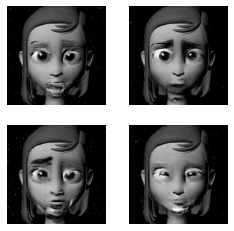

In [22]:
d1,d2,g=train(genmodel, discmodel, cganmodel, dataset, latent_dim)

In [ ]:
genmodel.save_weights('C:\\Users\\Lanxiang Guo\\ai\\model\\cgan_generator.h5')
cganmodel.save_weights("C:\\Users\\Lanxiang Guo\\ai\\model\\cgan.h5")

In [ ]:
#angry - disgust - fear - happy

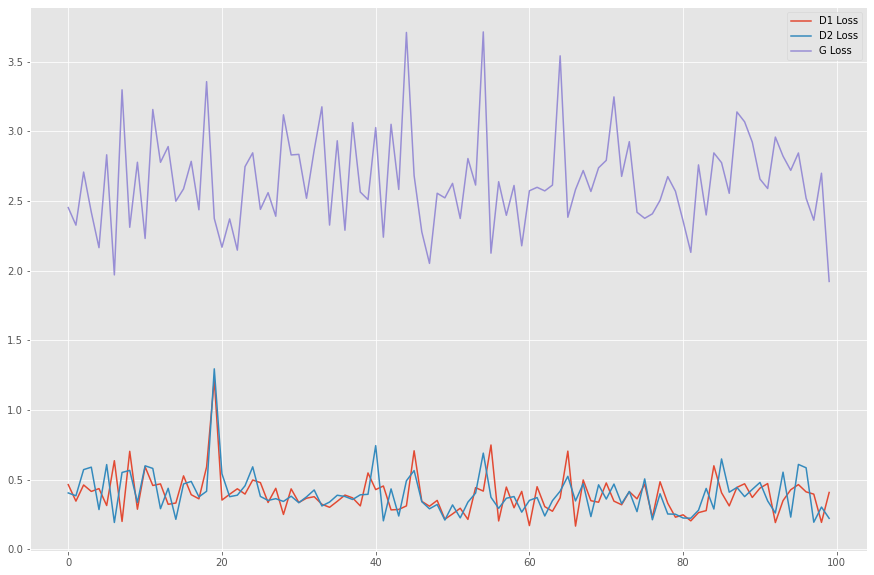

In [23]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(15,10))
plt.plot(d1[-100:],label='D1 Loss')
plt.plot(d2[-100:],label='D2 Loss')
plt.plot(g[-100:],label='G Loss')
plt.legend()
plt.show()

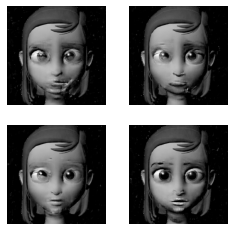

In [24]:
plot(genmodel,generate_latent_points(100, 4))

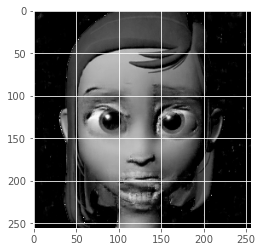

In [25]:
plt.imshow(genmodel(seed,training=False)[0].numpy().reshape(256,256),cmap='gray')


In [ ]:
cganmodel.summary()

In [ ]:
discmodel([img[0:4],np.array([0,1,2,3])])

In [ ]:
test_input,y=generate_latent_points(100, 4)
y=np.asarray([3,4,5,6])
seed = [test_input,y]
plot(genmodel,seed)


In [ ]:
plt.imshow(genmodel(seed,training=False)[3].numpy().reshape(256,256),cmap='gray')
plt.axis('off')
plt.savefig('D:\image data\jaffe\FE\image1.jpg', bbox_inches='tight',pad_inches = 0)
name

In [ ]:
balance = 9169
total = 8571
needcreate = balance - total
for i in range(0,needcreate,1):
    test_input,y=generate_latent_points(100, 4)
    y=np.asarray([1,2,3,4])
    seed = [test_input,y]
    plot(genmodel,seed)
    plt.imshow(genmodel(seed,training=False)[0].numpy().reshape(256,256),cmap='gray')
    plt.axis('off')
    plt.savefig('C:\\xunleixiazai\\newferdb\\disgust\\di%d.jpg'%i, bbox_inches='tight',pad_inches = 0)

In [ ]:
balance = 9169
total = 7419
needcreate = balance - total
for i in range(0,needcreate,1):
    test_input,y=generate_latent_points(100, 4)
    y=np.asarray([1,2,3,4])
    seed = [test_input,y]
    plot(genmodel,seed)
    plt.imshow(genmodel(seed,training=False)[1].numpy().reshape(256,256),cmap='gray')
    plt.axis('off')
    plt.savefig('C:\\xunleixiazai\\newferdb\\fear\\fear%d.jpg'%i, bbox_inches='tight',pad_inches = 0)

In [ ]:
balance = 9169
total = 7330
needcreate = balance - total
for i in range(0,needcreate,1):
    test_input,y=generate_latent_points(100, 4)
    y=np.asarray([1,2,3,4])
    seed = [test_input,y]
    plot(genmodel,seed)
    plt.imshow(genmodel(seed,training=False)[2].numpy().reshape(256,256),cmap='gray')
    plt.axis('off')
    plt.savefig('C:\\xunleixiazai\\newferdb\\happy\\happy%d.jpg'%i, bbox_inches='tight',pad_inches = 0)

In [ ]:
balance = 9169
total = 6939
needcreate = balance - total
for i in range(0,needcreate,1):
    test_input,y=generate_latent_points(100, 4)
    y=np.asarray([1,2,3,4])
    seed = [test_input,y]
    plot(genmodel,seed)
    plt.imshow(genmodel(seed,training=False)[3].numpy().reshape(256,256),cmap='gray')
    plt.axis('off')
    plt.savefig('C:\\xunleixiazai\\newferdb\\neutral\\neutral%d.jpg'%i, bbox_inches='tight',pad_inches = 0)

In [ ]:
balance = 9169
total = 7627
needcreate = balance - total
for i in range(0,needcreate,1):
    test_input,y=generate_latent_points(100, 4)
    y=np.asarray([0,1,2,5])
    seed = [test_input,y]
    plot(genmodel,seed)
    plt.imshow(genmodel(seed,training=False)[3].numpy().reshape(256,256),cmap='gray')
    plt.axis('off')
    plt.savefig('C:\\xunleixiazai\\newferdb\\sad\\sad%d.jpg'%i, bbox_inches='tight',pad_inches = 0)

In [ ]:
balance = 9169
total = 8712
needcreate = balance - total
for i in range(0,needcreate,1):
    test_input,y=generate_latent_points(100, 4)
    y=np.asarray([0,1,2,6])
    seed = [test_input,y]
    plot(genmodel,seed)
    plt.imshow(genmodel(seed,training=False)[3].numpy().reshape(256,256),cmap='gray')
    plt.axis('off')
    plt.savefig('C:\\xunleixiazai\\newferdb\\surprise\\surprise%d.jpg'%i, bbox_inches='tight',pad_inches = 0)